# Example: Utilizing Predictive and Deterministic with MCMC and SVI

In this short tutorial we'll see how to use `deterministic` statements inside a model and inspect its samples with `Predictive` class. Additionally a `GammaPoisson` distribution will be discussed as it'll be used within our model.

Check out other tutorials that use `Predictive` and `Deterministic`:

- [Example: analyzing baseball stats with MCMC](http://pyro.ai/examples/baseball.html)
- [Bayesian Regression - Inference Algorithms (Part 2)](http://pyro.ai/examples/bayesian_regression_ii.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.mcmc.util import summary
from pyro.distributions import constraints
import pyro
import torch

pyro.set_rng_seed(101)

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Data generation

Let's generate our data with `sklearn.datasets.make_regression` method where we can determine the number of features, bias and noise power. Also we'll transform the target variable and make it a `torch` tensor.

In [2]:
X, y = make_regression(n_features=1, bias=150., noise=5., random_state=108)

X_ = torch.tensor(X, dtype=torch.float)
y_ = torch.tensor((y**3)/100000. + 10., dtype=torch.float)

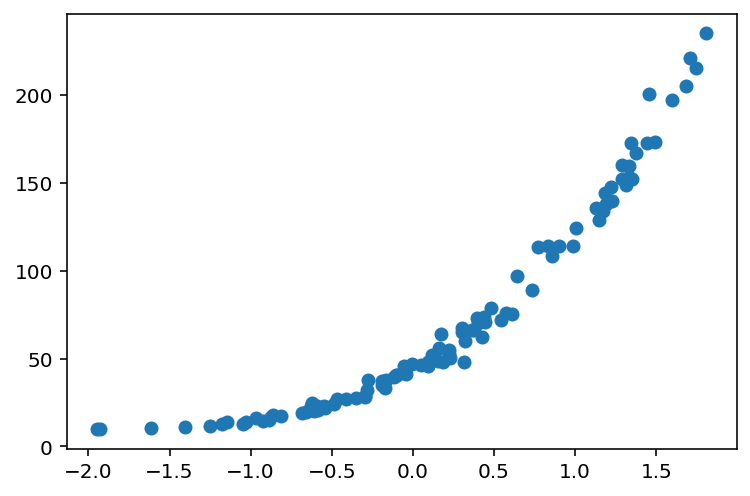

In [3]:
plt.scatter(X_, y_);

## Model definition

In our model we first sample coefficient from a normal distribution with zero mean and sampled standard deviation. We use `to_event(1)` to move the expanded dimension from `batch_size` to `event_size` as we want to sample from a multivariate normal distribution. `deterministic` part is used to register a `name` whose `value` is fully determined by arguments passed to it. Here we use `softplus` to be sure that the resulting `rate` isn't negative. Then we use vectorized version of `plate` to record `counts` from passed dataset as they were sampled from `GammaPoisson` distribution. 

For now this model might be a little obscure but later we will dive into sampled data to better grasp it's internals.

In [4]:
def model(features, counts):
    N, P = features.shape
    scale = pyro.sample("scale", dist.LogNormal(0, 1))
    coef = pyro.sample("coef", dist.Normal(0, scale).expand([P]).to_event(1))
    rate = pyro.deterministic("rate", torch.nn.functional.softplus(coef @ features.T))
    concentration = pyro.sample("concentration", dist.LogNormal(0, 1))
    with pyro.plate("bins", N):
        return pyro.sample("counts", dist.GammaPoisson(concentration, rate, validate_args=False), obs=counts)

## Inference

Inference will be done with MCMC algorithm. IMPORTANT! Please note that only `scale` and `coef` variables are returned in samples dict. `deterministic` parts are available via `Predictive`, similarly as observed samples.

In [5]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=500)

In [6]:
%%time

mcmc.run(X_, y_);

Sample: 100%|██████████| 1000/1000 [00:22, 43.82it/s, step size=6.35e-01, acc. prob=0.900]

CPU times: user 22.3 s, sys: 325 ms, total: 22.6 s
Wall time: 22.8 s


In [7]:
samples = mcmc.get_samples()
print(samples.keys())

dict_keys(['scale', 'coef', 'concentration'])


In [8]:
predictive = Predictive(model, samples)(X_, None)
print(predictive.keys())

dict_keys(['counts', 'rate'])


After sampling let's see how well our model fits the data. We compute sampled `counts` mean and standard deviation and plot it against the original data.

In [9]:
def prepare_counts_df(predictive):
    counts = predictive['counts'].numpy()
    counts_mean = counts.mean(axis=0)
    counts_std = counts.std(axis=0)
    
    counts_df = pd.DataFrame({
    "feat": X_.squeeze(),
    "mean": counts_mean,
    "high": counts_mean + counts_std,
    "low": counts_mean - counts_std,
    })

    return counts_df.sort_values(by=['feat'])

In [10]:
counts_df = prepare_counts_df(predictive)

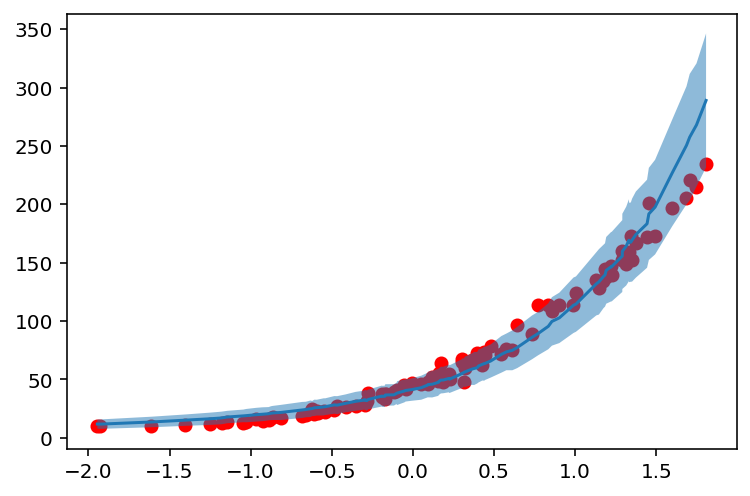

In [11]:
plt.scatter(X_, y_, c='r')
plt.plot(counts_df['feat'], counts_df['mean'])
plt.fill_between(counts_df['feat'], counts_df['high'], counts_df['low'], alpha=0.5);

But where do these values (and uncertainty) come from? Let's find out!

## Inspecting deterministic part

Now let's move to the essence of this tutorial. `GammaPoisson` distribution used here and parameterized with (`concentration`, `rate`) arguments is basically an alternative parametrization of `NegativeBinomial` distribution. 

`NegativeBinomial` answers a question: How many successes will we record before seeing `r` failures (overall) if each trial wins with probability `p`? 

The reparametrization occurs as follows:

- `concentration = r`
- `rate = 1 / (p + 1)`

First we check sampled mean of `concentration` and `coef` variables...

In [12]:
print('Concentration mean: ', samples['concentration'].mean().item())
print('Concentration std: ', samples['concentration'].std().item())

Concentration mean:  28.858654022216797
Concentration std:  0.8479085564613342


In [13]:
print('Coef mean: ', samples['coef'].mean().item())
print('Coef std: ', samples['coef'].std().item())

Coef mean:  -1.2455012798309326
Coef std:  0.037528540939092636


...and do reparametrization (again please note that we get it from `predictive`!).

In [14]:
rates = predictive['rate'].squeeze()
rates_reparam = 1. / (rates + 1.) # here's reparametrization

Now we plot reparametrized `rate`:

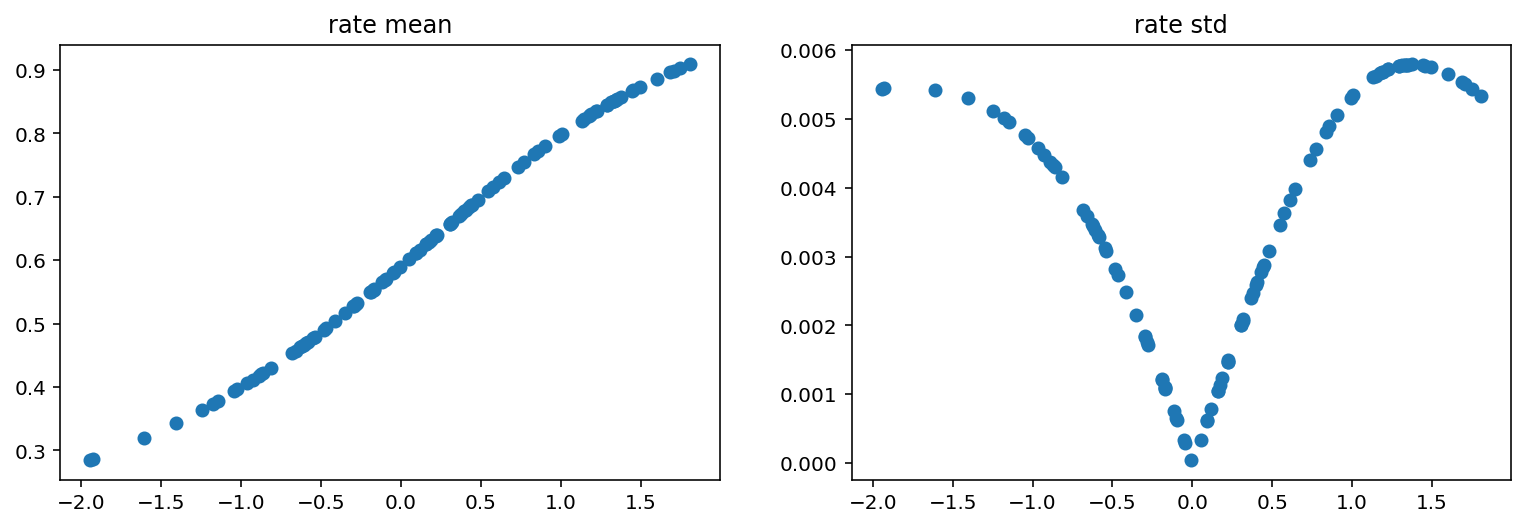

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(13, 4)

ax1.scatter(X_, rates_reparam.mean(axis=0))
ax1.set_title('rate mean')
ax2.scatter(X_, rates_reparam.std(axis=0))
ax2.set_title('rate std');

We see that the probability of success rises with `x`. This means that it will take more and more trials before we observe those 28 failures imposed by `concentration` parameter.

Intuitively if we want to record 28 failures where each failure occurs with probability 0.5 then it should also take 28 successes. Let's check if our model follows this logic:

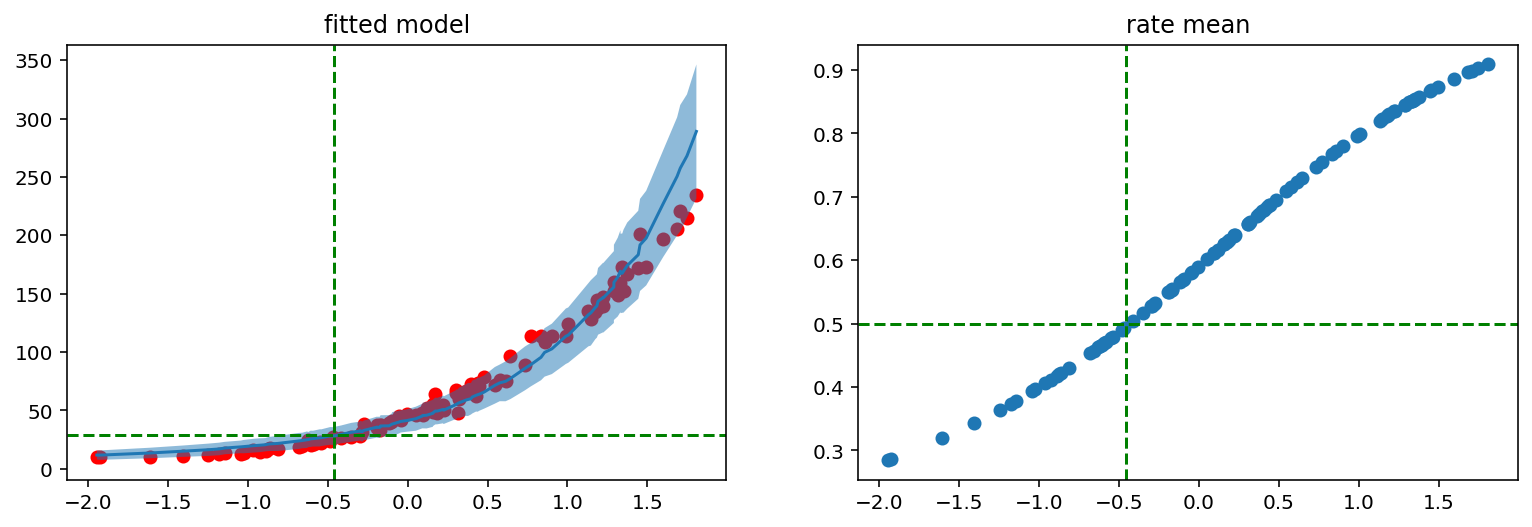

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(13, 4)

ax1.scatter(X_, y_, c='r')
ax1.plot(counts_df['feat'], counts_df['mean'])
ax1.fill_between(counts_df['feat'], counts_df['high'], counts_df['low'], alpha=0.5)
ax1.axhline(samples['concentration'].mean().item(), c='g', linestyle='dashed')
ax1.axvline(-0.46, c='g', linestyle='dashed')
ax1.set_title('fitted model')
ax2.scatter(X_, rates_reparam.mean(axis=0))
ax2.axhline(0.5, c='g', linestyle='dashed')
ax2.axvline(-0.46, c='g', linestyle='dashed')
ax2.set_title('rate mean');

It indeed does. Red lines show that 28 successes and rate 0.5 are located with the same `x` argument. 

## SVI approach

`Predictive` class can also be used with the SVI method. In the next section we will use it with `AutoGuide`'s guide and manually designed one.

In [17]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoNormal

### Manually defined guide

First we define our guide with all `sample` sites that are present in the model and parametrize them with learnable parameters. Then we perform gradient descent with `Adam` optimizer.

In [18]:
def guide(features, counts):
    N, P = features.shape
    
    scale_param = pyro.param("scale_param", torch.tensor(0.1), constraint=constraints.positive)
    loc_param = pyro.param("loc_param", torch.tensor(0.0))
    scale = pyro.sample("scale", dist.Delta(scale_param))
    coef = pyro.sample("coef", dist.Normal(loc_param, scale).expand([P]).to_event(1))
    
    concentration_param = pyro.param("concentration_param", torch.tensor(0.1), constraint=constraints.positive)
    concentration = pyro.sample("concentration", dist.Delta(concentration_param))

In [19]:
pyro.clear_param_store()

adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [20]:
%%time

n_steps = 5001

for step in range(n_steps):
    loss = svi.step(X_, y_)
    if step % 1000 == 0:
        print('Loss: ', loss)

Loss:  4083.343687057495
Loss:  467.4017288684845
Loss:  394.44257640838623
Loss:  408.9837645292282
Loss:  409.8578680753708
Loss:  394.2356821298599
CPU times: user 23.6 s, sys: 226 ms, total: 23.8 s
Wall time: 24.5 s


`Pyro`s parameter store is comprised of learned parameters that will be used in `Predictive` stage. Instead of providing samples we pass `guide` parameter to construct predictive distribution.

In [21]:
list(pyro.get_param_store().items())

[('scale_param', tensor(0.1934, grad_fn=<AddBackward0>)),
 ('loc_param', tensor(-1.1939, requires_grad=True)),
 ('concentration_param', tensor(28.2309, grad_fn=<AddBackward0>))]

In [22]:
predictive_svi = Predictive(model, guide=guide, num_samples=500)(X_, None)
print(predictive_svi.keys())

dict_keys(['scale', 'coef', 'concentration', 'counts', 'rate'])


In [23]:
counts_df = prepare_counts_df(predictive_svi)

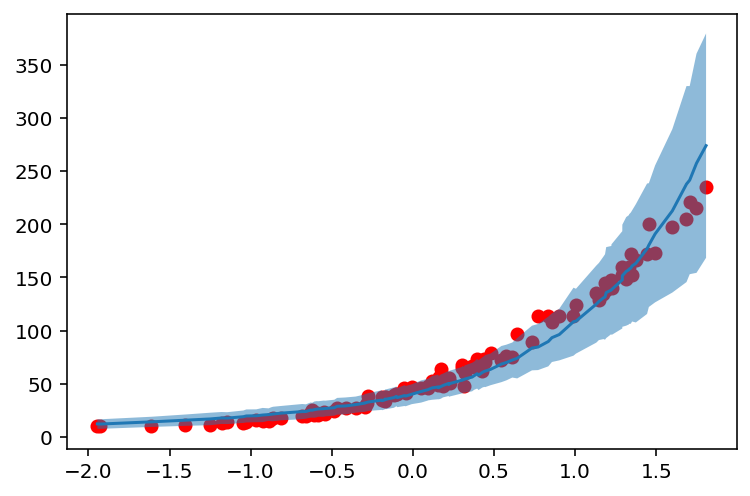

In [24]:
plt.scatter(X_, y_, c='r')
plt.plot(counts_df['feat'], counts_df['mean'])
plt.fill_between(counts_df['feat'], counts_df['high'], counts_df['low'], alpha=0.5);

### AutoGuide

Another approach for conducting SVI is to rely on automatic guide generation. Here we use `AutoNormal` that underneath uses a normal distribution with a diagonal covariance matrix.

In [25]:
pyro.clear_param_store()

adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

auto_guide = AutoNormal(model)

svi = SVI(model, auto_guide, optimizer, loss=Trace_ELBO())

In [26]:
%%time

n_steps = 3001

for step in range(n_steps):
    loss = svi.step(X_, y_)
    if step % 1000 == 0:
        print('Loss: ', loss)

Loss:  4005.407080989331
Loss:  379.12515234947205
Loss:  376.1868230998516
Loss:  376.45190131664276
CPU times: user 18.8 s, sys: 47.8 ms, total: 18.9 s
Wall time: 18.9 s


In [27]:
auto_guide(X_, y_)

{'scale': tensor(1.0996, grad_fn=<ExpandBackward>),
 'coef': tensor([-1.2571], grad_fn=<ExpandBackward>),
 'concentration': tensor(28.2732, grad_fn=<ExpandBackward>)}

As we check `PARAM_STORE` we see that each `sample` site is approximated with a normal distribution. 

In [28]:
list(pyro.get_param_store().items())

[('AutoNormal.locs.scale',
  Parameter containing:
  tensor(0.3109, requires_grad=True)),
 ('AutoNormal.scales.scale', tensor(0.5159, grad_fn=<AddBackward0>)),
 ('AutoNormal.locs.coef',
  Parameter containing:
  tensor([-1.2521], requires_grad=True)),
 ('AutoNormal.scales.coef', tensor([0.0397], grad_fn=<AddBackward0>)),
 ('AutoNormal.locs.concentration',
  Parameter containing:
  tensor(3.3570, requires_grad=True)),
 ('AutoNormal.scales.concentration', tensor(0.0291, grad_fn=<AddBackward0>))]

Finally we again construct a predictive distribution and plot `counts`. For all three methods we managed to get similar results for our parameters. 

In [29]:
predictive_svi = Predictive(model, guide=auto_guide, num_samples=500)(X_, None)
print(predictive_svi.keys())

dict_keys(['scale', 'coef', 'concentration', 'counts', 'rate'])


In [30]:
counts_df = prepare_counts_df(predictive_svi)

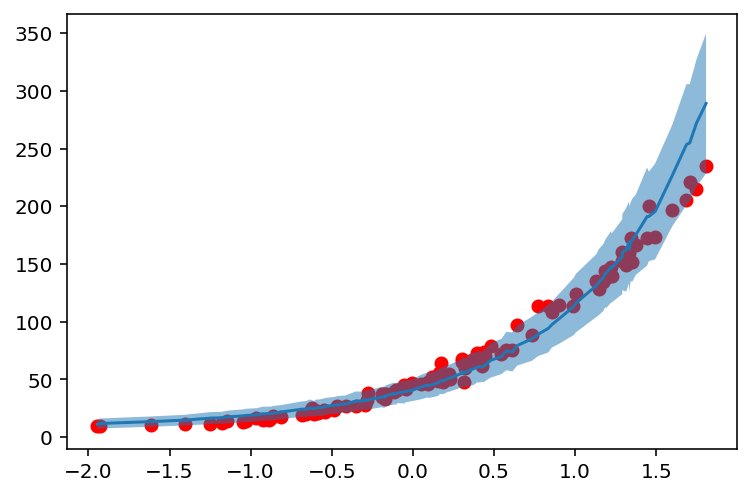

In [31]:
plt.scatter(X_, y_, c='r')
plt.plot(counts_df['feat'], counts_df['mean'])
plt.fill_between(counts_df['feat'], counts_df['high'], counts_df['low'], alpha=0.5);